This program runs the Time Difference of Arrival Target Motion Analysis (TD-TMA) algorithm. For convenience, all functions run under the same notebook. The key function is LMM (Levenberg–Marquardt Method) to find the least squares solution of the target. After which a basing hopping algorithm is used to find the global minima from all possible solutions. To compare results to traditional multilateration the class Benchmark is used, which uses 3 TDOA isolines to localize the target. In case the isoline do not intersect at a single point, the Fermat point is chosen.
The main variables are:d
    Xo, Yo - observer coordinates
    RealXt, RealYt - target's true coordinates
    Xt, Yt - target's estimated coordinates (solution of the TD-TMA)
    c - actual speed of sound
    c1 - default speed of sound (1500)
    Ceff - sound velocity a perceived by the target's solution
    Cbasin - sound velocity found by the TD-TMA algorithm    

In [1]:
%matplotlib notebook
import pycodestyle_magic 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import fsolve, basinhopping
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


In [5]:
# %%pycodestyle #style checking


def TDTMA(Vt, Ct, Vo1, Vo2, Co, Omaneuver, TINoise, TDNoise, TrackingNoise,
          N, TI, c, c1, numguess):
    # temporary variables used as accumulators to save the best solution after
    # runing the LMM, numguess - number of initial position guesses
    XT = np.zeros(numguess)
    YT = np.zeros(numguess)
    VE = np.zeros(numguess)
    CE = np.zeros(numguess)
    SOLResidual = np.zeros(numguess)
    CEFF = np.zeros(numguess)
    k = np.pi/180
    TxTime = np.linspace(0, (N-1) * TI, N)
    TxTime[1:N] = TxTime[1:N] + TINoise

# Target coordinates at Tx time
    # initial position X + noise
    RealXtini = 20 + np.sin(Ct * k) * TrackingNoise[0, 0]
    # initial position Y + noise
    RealYtini = 30 + np.cos(Ct * k) * TrackingNoise[0, 0]
    RealXt = RealXtini + Vt * np.sin(Ct * k) * TxTime
    RealYt = RealYtini + Vt * np.cos(Ct * k) * TxTime

# Observer coordinates at reception time
    Xo = np.zeros(N)
    Yo = np.zeros(N)
    Xini = 0.0    # initial position X
    Yini = 600.0  # initial position Y
    TOF = np.zeros(N)

#  Find the tof at each transmission
    for i in range(0, MP):
        def eq1(tof):
            return np.sqrt((RealXt[i] - (Xini + Vo1 * np.sin(Co * k) *
                                         (TI * (i) + tof))) ** 2 +
                           (RealYt[i] - (Yini + Vo1 * np.cos(Co * k) *
                                         (TI * (i) + tof))) ** 2)/c - tof
        tof = fsolve(eq1, 0)
        TOF[i] = tof
    Xo[:MP] = Xini + Vo1 * np.sin(Co * k)*(TxTime[:MP] + TOF[:MP])
    Yo[:MP] = Yini + Vo1 * np.cos(Co * k)*(TxTime[:MP] + TOF[:MP])
    for i in range(MP, N):
        def eq2(tof):
            return np.sqrt((RealXt[i] -
                            (Xo[MP - 1] + Vo2 * np.sin((Co + Omaneuver) * k) *
                             (TI * (i - MP + 1) + tof))) ** 2 +
                           (RealYt[i] - (Yo[MP - 1] + Vo2 *
                                         np.cos((Co + Omaneuver) * k)
                                         * (TI*(i - MP + 1) + tof))) ** 2) \
                     / c - tof
        tof = fsolve(eq2, 0)
        TOF[i] = tof
    Xo[MP:] = Xo[MP-1] + Vo2 * np.sin((Co + Omaneuver) * k) * (
        TxTime[MP:] + TOF[MP:]-(MP - 1) * TI)
    Yo[MP:] = Yo[MP-1] + Vo2 * np.cos((Co + Omaneuver) * k) * (
        TxTime[MP:] + TOF[MP:] - (MP - 1) * TI)
    RxTime = TxTime + TOF
    TDOA = np.diff(RxTime)
    TDOA = TDOA + TDNoise

# Internal tests (used during development, not used in the simulation)
    # TOF
    dX = RealXt - Xo
    dY = RealYt - Yo
    TOFs = ((dX ** 2 + dY ** 2) ** 0.5) / c
    # TDOA
    TDOAcheck = np.diff(TOFs)+TI
    # not in used - kind of internal check
    RealResidual = sum((TDOAcheck - TDOA) ** 2)

# find the first TDOA (hyperbola) line on which the target lays.
# On this line inital "numguess" solutions.
    TDOAXline, TDOAYline, IniInd = TDOALine(RealXt, RealXt, Xo, Yo,
                                            TDOA, Vt, Ct, TI, c1)
    # initial target speed guess
    Vtguess = Vt + 0.6 * np.random.uniform(1) - 0.3
    # initial target course guess
    Ctguess = Ct + 20 * np.random.uniform(1) - 10
    for i in range(0, numguess):
        # if a solution on TDOA line is not found for what\
        # so ever reason, give arbitrary initial position
        if IniInd[0] == -1:
            if i < numguess / 2:
                # the +1 if just for avoidung numerical problems while
                # calculating the Jacobian
                Xtguess = Xo[0] - i / numguess * np.sin(45 * k) * 1500 + 1
                Ytguess = Yo[0] + i / numguess * np.cos(45 * k) * 1500 + 1
            else:
                Xtguess = Xo[0] - (numguess - 1 - i) / numguess\
                 * np.sin(45 * k) * 1500 + 1
                Ytguess = Yo[0] - (numguess - 1 - i) / numguess\
                    * np.cos(45 * k) * 1500 + 1
        else:
            Xtguess = TDOAXline[IniInd[i]]
            Ytguess = TDOAYline[IniInd[i]]

        Xtini, Ytini, Vest, Cest = LMM(TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver,
                                       N, Xtguess, Ytguess, Vtguess, Ctguess,
                                       TI, c1)
# save numguess solutions and choose the one with
# the smallest solotion error
        XT[i] = Xtini
        YT[i] = Ytini
        VE[i] = Vest
        CE[i] = Cest
        # temporary - only for the ith iteration
        Xt = Xtini + Vest * np.sin(Cest * k) * TxTime
        # temporary - only for the ith iteration
        Yt = Ytini + Vest * np.cos(Cest * k) * TxTime
        Ceff = EFF(Xt, Yt, Xo, Yo, TDOA, TI)
        CEFF[i] = Ceff
        SolTDOA = np.diff((((Xt - Xo) ** 2 + (Yt - Yo) ** 2) ** 0.5) /
                          Ceff + TI * np.arange(0, N))
        SOLResidual[i] = sum((SolTDOA-TDOA) ** 2)
    # choose the one with the smallest Residual compared to the
    # measured TDOA
    j = np.argmin(SOLResidual)
    Xtini = XT[j]
    Ytini = YT[j]
    Vest = VE[j]
    Cest = CE[j]
    Ceff = CEFF[j]
    # in case none of the "numgues"s solutions converged, SOLR will be >=1
    SOLR = SOLResidual[j]
    Ceff1, SOLR1 = (Ceff, SOLR)

# the BH algorithm
    x0 = 1470
    minimizer_kwargs = {"method": 'L-BFGS-B', "args":
                        (TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver, N, Xtini,
                         Ytini, Vest, Cest, TI, TxTime), "bounds":
                                                         [(1470, 1530)]}
    ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=20,
                       T=1e-8, stepsize=10)
    Xtini, Ytini, Vest, Cest = LMM(TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver, N,
                                   Xtini, Ytini, Vest, Cest, TI, ret.x)
    Xt = Xtini + Vest * np.sin(Cest * k) * TxTime
    Yt = Ytini + Vest * np.cos(Cest * k) * TxTime
    Ceff = EFF(Xt, Yt, Xo, Yo, TDOA, TI)
    SolTDOA = np.diff((((Xt - Xo) ** 2 + (Yt - Yo) ** 2) ** 0.5)
                      / Ceff + TI * np.arange(0, N))
    SOLR = sum((SolTDOA - TDOA) ** 2)
    return Xo, Yo, RealXt, RealYt, Xt, Yt, Cest, Vest, Ctguess, Vtguess, \
        TDOA, TDOAXline, TDOAYline, IniInd, Ceff, SOLR, RealResidual, ret.x


def func(x0, TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver, N, Xtini, Ytini, Vest,
         Cest, TI, TxTime):
    k = np.pi/180
    Xtini, Ytini, Vest, Cest = LMM(TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver,
                                   N, Xtini, Ytini, Vest, Cest, TI, x0)
    Xt = Xtini + Vest*np.sin(Cest * k) * TxTime
    Yt = Ytini + Vest*np.cos(Cest * k) * TxTime
    SolTDOA = np.diff((((Xt - Xo) ** 2 + (Yt - Yo) ** 2) ** 0.5) / x0 + TI
                      * np.arange(0, N))
    return(sum((SolTDOA - TDOA) ** 2))


# calculate the first TDOA line and posible inital target positions
# for simulation I use only the first TDOA line.
def TDOALine(RealXt, RealYt, Xo, Yo, TDOA, Vt, Ct, TI, c1):
    c = c1
    k = np.pi/180
    # TDOA line range
    minx = min(np.concatenate([np.asarray(RealXt), np.asarray(Xo)])) - 1000
    maxx = max(np.concatenate([np.asarray(RealXt), np.asarray(Xo)])) + 1000
    miny = min(np.concatenate([np.asarray(RealYt), np.asarray(Yo)])) - 1000
    maxy = max(np.concatenate([np.asarray(RealYt), np.asarray(Yo)])) + 1000
    # TDOA line equation

    def eq3(Ytline):
        return (np.sqrt((Xtline + Vt * np.sin(Ct * k) * TI - Xo[1]) ** 2 +
                        (Ytline + Vt * np.cos(Ct * k) * TI-Yo[1]) ** 2) / c -
                np.sqrt((Xtline-Xo[0]) ** 2 + (Ytline - Yo[0]) ** 2)
                / c-TDOA[0] + TI)
    TDOAXline = []
    TDOAYline = []
    yguess1 = maxy / 2
    yguess2 = miny / 2
    for Xtline in np.linspace(minx, maxx, 2000):
        Ytline = fsolve(eq3, yguess1, full_output=True)
        if Ytline[2] == 1:
            yguess1 = Ytline[0]
            TDOAXline.append(Xtline)
            TDOAYline.append(Ytline[0].item())
            Ytline = fsolve(eq3, yguess2, full_output=True)
            # due to numerical precision didn't use !=
            if Ytline[2] == 1 and np.absolute(Ytline[0] - TDOAYline[-1])\
            > 0.000001:
                yguess2 = Ytline[0]
                TDOAXline.append(Xtline)
                TDOAYline.append(Ytline[0].item())
            else:
                yguess2 = miny / 2
        else:
            yguess1 = maxy / 2
    # find initial guess positions along the first TDOA line from both sides
    # of the observer (omni-directional reception)
    if len(TDOAYline) > 0:  # if TDOA line's solution found, then....
        # keep TDOA line within the [-1500 1500] interval
        I1 = np.argmax(np.array(TDOAYline) < 1500)
        I2 = np.argmax(np.array(TDOAYline) < -1500)
        TDOAXline = TDOAXline[I1:I2]
        TDOAYline = TDOAYline[I1:I2]
        # print(I1, I2)
        # so to have even distance between the initial guess points
        delta = 2000 / numguess
        IniInd = np.zeros(numguess)
        # after limiting to [-1500 1500] verify that there is still
        # a line to work with
        if len(TDOAYline) > 0:
            # this is the closest point of the TDOA line to the observer
            ind = np.argmin((((Xo[0] - TDOAXline) ** 2+(Yo[0] - TDOAYline)
                              ** 2) ** 0.5))
            if ind > 0:
                for i in range(0, numguess):
                    if i < numguess / 2:
                        IniInd[i] = np.argmin((((Xo[0] - TDOAXline[:ind])
                                                ** 2 + (Yo[0]-TDOAYline[
                                                    :ind]) ** 2) ** 0.5)
                                              > 1000 - delta * i)
                    else:
                        IniInd[i] = np.argmax((((Xo[0] - TDOAXline[ind:])
                                                ** 2 + (Yo[0] - TDOAYline
                                                        [ind:]) ** 2)
                                               ** 0.5) > 1000 - delta * (
                            numguess - 1 - i)) + ind
            else:
                IniInd = - np.ones(numguess)
        else:
            IniInd = - np.ones(numguess)
    else:  # if no solution is found, just give an indication
        IniInd = - np.ones(numguess)
    IniInd = list(map(int, IniInd))
    return TDOAXline, TDOAYline, IniInd


# this is the LMM gradient descent
def LMM(TDOA, Xo, Yo, Vo1, Vo2, Co, Omaneuver, N, Xtguess, Ytguess,
        Vtguess, Ctguess, TI, c1):
    # LMM2 - Jacobian is calculated straight forward in a matrix form,
    #  and correction of LMM so that Vx Vy takes into considertion also the
    # observer's maneuver and corection of the Xt[0], Yt[0]
    # positionswith regards to previous LMM function.
    c = c1
    k = np.pi / 180
# Variables declaration
    Xt = np.zeros(N)
    Yt = np.zeros(N)
    Vox = np.array([Vo1 * np.sin(Co * k) * np.ones(int(N / 2)),
                    Vo2 * np.sin((Co + Omaneuver) * k) * np.ones(int(N / 2))])\
        .reshape(1, N)
    Voy = np.array([Vo1 * np.cos(Co * k) * np.ones(int(N / 2)),
                    Vo2 * np.cos((Co + Omaneuver) * k) * np.ones(int(N / 2))])\
        .reshape(1, N)
# calculating the Jacobian for N points and iterations
    Xt[0] = Xtguess
    Yt[0] = Ytguess
    Vx = Vtguess * np.sin(Ctguess * k) - Vo1 * np.sin(Co * k)
    Vy = Vtguess * np.cos(Ctguess * k) - Vo1 * np.cos(Co * k)
    Pold = np.array([Xt[0] - Xo[0], Yt[0] - Yo[0], Vx, Vy])
    lamda = 0.001
    Residual = 1
    lmmcount = 1
    # pure timeline since calculated so observer now aware to the noise
    Time = np.linspace(0, TI * (N-1), N)
    while (Residual > 1e-9 and lmmcount < 30):
        Vest = np.sqrt((Vx + Vo1 * np.sin(Co * k)) ** 2+(Vy + Vo1 *
                                                         np.cos(Co * k)) ** 2)
        Cest = np.arctan2((Vx + Vo1 * np.sin(Co * k)), (Vy + Vo1 *
                                                        np.cos(Co * k))) / k
        Xt = Xt[0] + Vest * np.sin(Cest * k) * Time
        Yt = Yt[0] + Vest * np.cos(Cest * k) * Time
        dX = Xt-Xo       # X distance target - observer
        dY = Yt-Yo       # Y distance target - observer
        Rto = np.sqrt(dX ** 2 + dY ** 2)  # target distance from observer
        # relative X speed target - observer
        dVx = Vest * np.sin(Cest * k) - Vox
        # relative Y speed target - observer
        dVy = Vest * np.cos(Cest * k) - Voy
        TDOAestimated = np.diff(Rto) / c + TI
        Residual = np.sum((TDOAestimated - TDOA) ** 2)
        J = np.transpose(np.reshape(
            np.array([(- (dX / (dX ** 2 + dY ** 2) ** (1 / 2) -
                     ((dX + dVx * (TI + dX / c)) * (dVx / c + 1)) /
                     ((dX + dVx * (TI + dX / c)) ** 2 + (dY + dVy * (TI + dY
                                                                     / c))
                      ** 2) ** (1 / 2)) / c),
                      (- (dY / (dX ** 2 + dY ** 2) ** (1 / 2) -
                          ((dY + dVy * (TI + dY / c)) * (dVy / c + 1)) /
                          ((dX + dVx * (TI + dX / c)) ** 2 + (dY + dVy *
                                                              (TI + dY / c))
                           ** 2) ** (1 / 2)) / c),
                      (((TI + dX / c) * (dX + dVx * (TI + dX / c))) /
                       (c * ((dX + dVx * (TI + dX / c)) ** 2 +
                             (dY + dVy * (TI + dY / c)) ** 2)
                        ** (1 / 2))),
                      (((TI + dY / c) * (dY + dVy * (TI + dY / c))) /
                       (c * ((dX + dVx * (TI + dX / c)) ** 2 +
                             (dY + dVy * (TI + dY / c)) ** 2)
                        ** (1 / 2)))]), (4, N)))

        J = J[0:N-1, ]  # there are only N-1 TDOA measurements
        A = np.matmul(np.transpose(J), J)  # alpha matrix
        # beta matrix
        B = np.matmul(np.transpose(J), np.transpose(TDOAestimated - TDOA))
# solution
        A1 = A
        for i in range(0, 4):
            A1[i, i] = A1[i, i] * (1 + lamda)
# same as the next line but  np.linalg.lstsq gives some warnings
#       dP = np.linalg.lstsq(-A1,B)[0]
        dP = -np.matmul(np.linalg.inv(A1), B)
        Pnew = Pold + np.transpose(dP)
# find new residual checking for convergence
        Xt[0] = Pnew[0] + Xo[0]
        Yt[0] = Pnew[1] + Yo[0]
        Vx = Pnew[2]
        Vy = Pnew[3]
        Vest = np.sqrt((Vx + Vo1 * np.sin(Co * k)) ** 2 +
                       (Vy + Vo1 * np.cos(Co * k)) ** 2)
        Cest = np.arctan2((Vx + Vo1 * np.sin(Co * k)),
                          (Vy + Vo1 * np.cos(Co * k)))/k
        Xt = Xt[0] + Vest * np.sin(Cest * k) * Time
        Yt = Yt[0] + Vest * np.cos(Cest * k) * Time
        dX1 = Xt - Xo        # X distance target - observer
        dY1 = Yt - Yo        # Y distance target - observer
        Rto1 = np.sqrt(dX1 ** 2 + dY1 ** 2)  # target distance from observer
        TDOAestimated1 = np.diff(Rto1) / c + TI
        ResidualNew = np.sum((TDOAestimated1 - TDOA) ** 2)
# Check convergence (whether better to increase od decrease lambda)
        if ResidualNew < Residual:
            lamda = lamda * 0.1
            Pold = Pnew  # old value get Pnew, Pnew = Pold+dP
        else:
            lamda = lamda * 10
            Pnew = Pold  # Pnew goes back to Pold, Pold is not changed
# next guess
        Xt[0] = Pnew[0] + Xo[0]
        Yt[0] = Pnew[1] + Yo[0]
        Vx = Pnew[2]
        Vy = Pnew[3]
        lmmcount += 1  # for m iterations or small enough residual
    Xtini = Xt[0]
    Ytini = Yt[0]
    Vest = np.sqrt((Vx + Vo1 * np.sin(Co * k)) **
                   2 + (Vy + Vo1 * np.cos(Co * k)) ** 2)
    Cest = np.arctan2((Vx + Vo1 * np.sin(Co * k)),
                      (Vy + Vo1 * np.cos(Co * k))) / k
    if Cest < 0:
        Cest = 360 + Cest
    return Xtini, Ytini, Vest, Cest


# Calculate the effective sound velocity based on the solution's
# target estimation and the measured TDOA. Use least squares
def EFF(Xt, Yt, Xo, Yo, TDOA, TI):
    Rdiff = np.diff(((Xt - Xo) ** 2 + (Yt - Yo) ** 2) ** 0.5)
    X = np.array([[np.ones(N - 1)], [TDOA - TI]]).reshape(2, N - 1)
    Beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X, np.transpose(X))),
                               X), np.transpose(Rdiff))
    Ceff = Beta[1]
    return Ceff


class Benchmark:  # standard triatelation as a benchmark

    def __init__(self, RealXt, RealYt, Rx, Ry, Ceff, N, NVar):
        self.RealXt = RealXt
        self.RealYt = RealYt
        self.Rx = Rx
        self.Ry = Ry
        self.Ceff = Ceff
        self.N = N
        self.NVar = NVar
        (self.TDOA12, self.TDOA13, self.TDOA23) = self.tdoa()

    def tdoa(self):
        D = lambda x, y, Rx1, Ry1, Rx2, Ry2, C, N:\
            (((x-Rx1) ** 2 + (y - Ry1) ** 2) ** 0.5 -
             ((x - Rx2) ** 2 + (y - Ry2) ** 2) ** 0.5) / C
        + np.random.normal(0, self.NVar/1500, N)
        TDOA12 = D(self.RealXt, self.RealYt, self.Rx[0], self.Ry[0],
                   self.Rx[1], self.Ry[1], self.Ceff, self.N)
        TDOA13 = D(self.RealXt, self.RealYt, self.Rx[0], self.Ry[0],
                   self.Rx[2], self.Ry[2], self.Ceff, self.N)
        TDOA23 = D(self.RealXt, self.RealYt, self.Rx[1], self.Ry[1],
                   self.Rx[2], self.Ry[2], self.Ceff, self.N)
        return(TDOA12, TDOA13, TDOA23)

    def find_p(self):
        temp = np.zeros([3, self.N, 2])
        positions = np.zeros([self.N, 2])
        zGuess = np.array([0, 0])
        for i in range(N):
            for j in range(3):
                node = [i, j]
                z = fsolve(self.triatelation, zGuess, node)
                temp[j, i, :] = z
            positions[i, :] = self.fermat(temp[0, i, :],
                                          temp[1, i, :], temp[2, i, :])
        return positions

    def triatelation(self, z, node):
        i = node[0]
        j = node[1]
        P = (lambda x, y, Rx1, Rx2, Ry1, Ry2, TD, C: ((
            (x - Rx1) ** 2 + (y - Ry1) ** 2) ** 0.5 -
            ((x - Rx2) ** 2 + (y - Ry2) ** 2) ** 0.5) / C - TD)
        x = z[0]
        y = z[1]
        F = np.empty((2))
        if j == 0:
            F[0] = P(x, y, self.Rx[0], self.Rx[1], self.Ry[0], self.Ry[1],
                     self.TDOA12[i], self.Ceff)
            F[1] = P(x, y, self.Rx[0], self.Rx[2], self.Ry[0], self.Ry[2],
                     self.TDOA13[i], self.Ceff)
        elif j == 1:
            F[0] = P(x, y, self.Rx[0], self.Rx[2], self.Ry[0], self.Ry[2],
                     self.TDOA13[i], self.Ceff)
            F[1] = P(x, y, self.Rx[1], self.Rx[2], self.Ry[1], self.Ry[2],
                     self.TDOA23[i], self.Ceff)
        else:
            F[0] = P(x, y, self.Rx[0], self.Rx[1], self.Ry[0], self.Ry[1],
                     self.TDOA12[i], self.Ceff)
            F[1] = P(x, y, self.Rx[1], self.Rx[2], self.Ry[1], self.Ry[2],
                     self.TDOA23[i], self.Ceff)
        return F

    # find the Fermat point of the 3 triatelation positions
    def fermat(self, p1, p2, p3):
        if self.NVar < 0.3:
            f = lambda A, B, C: (A + B + C) / 3
        else:
            d = lambda x, y:((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5
            s = lambda A, B, C:(d(B, C), d(C, A), d(A, B))
            j = lambda a, b, c:np.arccos(( b * b + c * c - a * a) / (2 * b * c))
            t = lambda a, b, c:1 / np.cos(j(a,b,c) - np.pi / 6)
            b = lambda A, B, C, p, q, r:[(p * A[i] + q * B[i] + r * C[i]) /\
                                         (p + q + r) for i in [0, 1]] 
            f = lambda A, B, C:A if j( * s(A, B, C)) >= 2 *np.pi / 3 else B\
            if j( * s(B, C, A)) >= 2 * np.pi / 3 \
            else C if j( *s(C, A, B)) >= 2 * np.pi / 3 else \
            b(A, B, C, d(B, C) * t( * s(A,B,C)), d(C, A) * t( * s(B, C, A)),
              d(A, B) * t( * s(C,A,B)))
        return f(p1, p2, p3)
    

+--------------------------+------------------------+-----------------------+------------------------+
| Parameter                | True                   | Estimated             | Error                  |
+==========================+========================+=======================+========================+
| Course [degree]          | 45.12113916144932      | 45.05008588725796     | 0.07105327419136387    |
+--------------------------+------------------------+-----------------------+------------------------+
| Speed [m/sec]            | 3.2444792241863873     | 3.2540292324056046    | 0.009550008219217254   |
+--------------------------+------------------------+-----------------------+------------------------+
| Mean Position Error [m]  |                        |                       | 30.249860785955086     |
+--------------------------+------------------------+-----------------------+------------------------+
| Mean Benchmark Error [m] |                        |                    

<IPython.core.display.Javascript object>


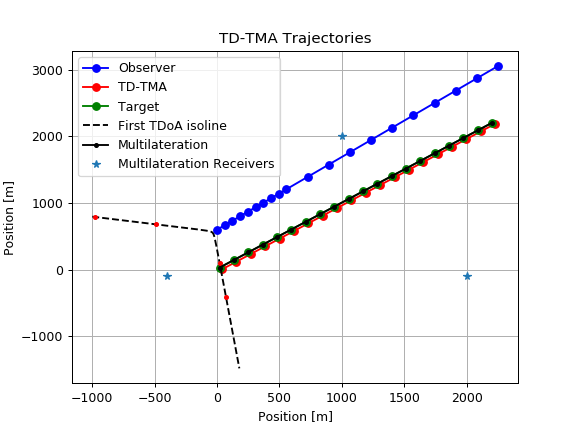

In [6]:
# %%pycodestyle #style checking

c1 = 1500.0   # default sound velocity -first guess
c = np.random.uniform(1470, 1530)   # true sound velocity
NVar = 0   # Noise variance
TI = 50.0  # Transmission Interval
N = 20     # Number of TMA cycles - N must be even \
# (for ease of simulation), maneuvering point (if any) always at N/2
if N % 2 == 1:
    N += 1
MP = int(N/2)  # Maneuveving point, jut to (keep N/2-1) integer
# num of ini guesses for solution search. Must be even (ease of simulation)
numguess = 4

# Benchmarking against standard triatelation
Rx = np.array([-400, 1000, 2000])
Ry = np.array([-100, 2000, -100])

# Noise parametes
# TDOA measurement noise - equivavlent up to 1 m error
TDNoise = 1 * np.random.normal(0, NVar/1500, N-1)
TINoise = 0 * np.random.rayleigh(1.0, N-1)       # TI noise - not in use here
Q = ([[(TI**3)/3, (TI**2)/2], [(TI**2)/2, TI]])  # Tracking noise cov. matrix
Mu = [0, 0]
q = 0.0
# Tracking noise covariance matrix - not in use here
TrackingNoise = q*np.random.multivariate_normal(Mu, Q, N)

# Target data - (keep Course and Speed values at this range, since TDOAlines
# depand on these valuses and TDOAline function is not so robust)
# target's speed m/s
Vt = 3 + np.random.uniform(0, 1) - 0.5 + np.linalg.norm(TrackingNoise[0])
Ct = 90 * np.random.uniform(0, 1)      # target's initial course

# Observer data
delta = 1.5 + 2 * np.random.uniform(0, 1)  # onserver speed alteration
Vo1 = Vt - 0.8 * delta  # observer's speed m/s
Vo2 = Vt + delta        # observer's speed m/s
Co = Ct + 10*np.random.uniform(0, 1) - 10  # observer's course degree
Omaneuver = 0.0  # observer course alteration, 0 for the speed alteration case

Xo, Yo, RealXt, RealYt, Xt, Yt, Cest, Vest, Ctguess, Vtguess, TDOA, TDOAXline,\
                                TDOAYline, IniInd, Ceff, SOLR, RealResidual, \
                                Cbasin = TDTMA(Vt, Ct, Vo1, Vo2, Co, Omaneuver,
                                               TINoise, TDNoise, TrackingNoise,
                                               N, TI, c, c1, numguess)
if Cest < 0:
    Cest = 360+Cest

# for benchmark comparison
t = Benchmark(RealXt, RealYt, Rx, Ry, Ceff, N, NVar)
positions = t.find_p()

# Analysis - data collection -
# basically used for the case of multiple runs. Very limired usage here
data = [(c, N, TI, Vt, Ct, Vo1, Vo2, Co, Xo, Yo, RealXt, RealYt, Xt, Yt, Vest,
         Cest, Ceff, Cbasin, SOLR, NVar, positions[:, 0], positions[:, 1])]
Result_df = pd.DataFrame(data, columns=['c', 'N', 'TI', 'Vt', 'Ct', 'Vo1',
                                        'Vo2', 'Co', 'Xo', 'Yo', 'RealXt',
                                        'RealYt', 'Xt', 'Yt', 'Vest', 'Cest',
                                        'Ceff', 'Cbasin', 'SOLR', 'Nvar',
                                        'Benchmark X', 'Benchmark Y'])
# RMS for estimaed position
Result_df['MeanRangeError'] = (((Result_df['Xt'] - Result_df['RealXt']) ** 2 +
                                (Result_df['Yt'] - Result_df['RealYt']) ** 2)
                               ** 0.5).apply(lambda x: sum(x))/Result_df['N']

# RMS for Benchmark error (realized in an alternative way to the above)
Result_df['BenchRangeError'] = (((Result_df['Benchmark X'] - Result_df[
                                 'RealXt']) ** 2 + (Result_df['Benchmark Y']
                                - Result_df['RealYt']) ** 2) ** 0.5)\
                                .map(sum)/Result_df['N']


print(tabulate([['Course [degree]', Ct, Cest, abs(Ct-Cest)],
                ['Speed [m/sec]', Vt, Vest, abs(Vt-Vest)],
                ['Mean Position Error [m]', '', '',
                 Result_df['MeanRangeError'][0]],
                ['Mean Benchmark Error [m]', '', '',
                 Result_df['BenchRangeError'][0]],
                ['Residual [sec]', RealResidual, SOLR, ''],
                ['Noise Variance ', NVar, '', '']],
               headers=['Parameter', 'True', 'Estimated', 'Error'],
               tablefmt="grid",
               numalign="left", stralign='left'))
print()
print(tabulate([['Sound Velocity [m/sec]', Ceff, Cbasin, c]],
               headers=['Estimated C LS', 'Estimated C BH', 'True C'],
               floatfmt=('.4f'), tablefmt="grid"))

plt.figure(1)
plt.plot(Xo, Yo, 'bo-', label='Observer')
plt.plot(Xt, Yt, 'ro-', label='TD-TMA')
plt.plot(RealXt, RealYt, 'go-', label='Target')
plt.plot(TDOAXline, TDOAYline, 'k--', label='First TDoA isoline')
iniguessX = np.zeros(numguess)
iniguessY = np.zeros(numguess)
if IniInd[0] != -1:
    for i in range(0, numguess):
        iniguessX[i] = TDOAXline[IniInd[i]]
        iniguessY[i] = TDOAYline[IniInd[i]]
plt.plot(iniguessX, iniguessY, 'r.')
plt.plot(positions[:, 0], positions[:, 1], 'k.-', label='Multilateration')
plt.plot(Rx, Ry, '*', label='Multilateration Receivers')
# plt.xlim(-100, 2000)
# plt.ylim(-2000, 2000)
plt.grid(True)
plt.legend()
plt.title('TD-TMA Trajectories')
plt.xlabel('Position [m]')
plt.ylabel('Position [m]')
plt.show()
